# Portfolio Optimisation using LSTM

In this project, we aim to optimize a portfolio of Moroccan companies (Attijariwafa bank (AWB), Maroc Telecom (IAM), Bourse de Casablanca (BC), Société Générale des Travaux du Maroc (SGTM), Managem (MAN)) using a Long Short-Term Memory (LSTM) neural network model. We will retrieve historical stock data, preprocess it, train an LSTM model for each stock, and then evaluate the performance of the portfolio.

## Importing libraries

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

## Data Retrieval

We begin by fetching historical stock data from Yahoo Finance for selected Moroccan companies.

In [11]:
# Define the ticker symbols of Moroccan companies
ticker_symbols = ['AWB', 'IAM', 'BC', 'SGTM', 'MAN']

# Specify the time period for data retrieval
start_date = '2018-01-01'
end_date = '2023-01-01'

# Create an empty DataFrame to store the data
historical_data = None

# Iterate over each ticker symbol and retrieve historical data
for ticker_symbol in ticker_symbols:
    # Download historical data for the current ticker symbol
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    
    # Extract adjusted close prices and rename the column
    adj_close = data['Adj Close'].rename(ticker_symbol)
    
    # Concatenate the adjusted close prices with existing data
    if historical_data is None:
        historical_data = adj_close
    else:
        historical_data = pd.concat([historical_data, adj_close], axis=1)

# Display the first few rows of the combined dataset
print(historical_data.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

             AWB         IAM         BC   SGTM         MAN
Date                                                      
2018-01-02  3.90  136.850006  50.555782  0.001  106.863770
2018-01-03  3.90  138.050003  50.790543  0.001  107.150436
2018-01-04  3.86  140.000000  50.357132  0.001  108.507843
2018-01-05  3.86  140.500000  51.251049  0.001  108.819801
2018-01-08  4.20  140.250000  51.422607  0.001  109.865242


## Data Preprocessing

In [12]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AWB     20 non-null     float64
 1   IAM     1041 non-null   float64
 2   BC      1259 non-null   float64
 3   SGTM    1259 non-null   float64
 4   MAN     1259 non-null   float64
dtypes: float64(5)
memory usage: 59.0 KB


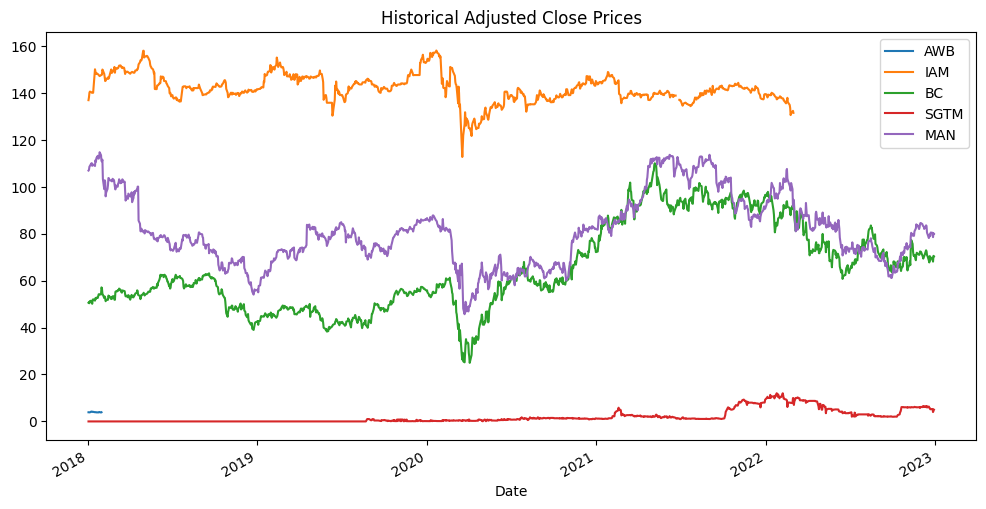

In [13]:
# Plot the time series data
historical_data.plot(figsize=(12,6))
plt.title('Historical Adjusted Close Prices')
plt.show()

In [14]:
# Resample the data to a daily frequency
historical_data = historical_data.resample('D').mean()

In [15]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2018-01-02 to 2022-12-30
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AWB     20 non-null     float64
 1   IAM     1041 non-null   float64
 2   BC      1259 non-null   float64
 3   SGTM    1259 non-null   float64
 4   MAN     1259 non-null   float64
dtypes: float64(5)
memory usage: 85.5 KB


In [16]:
# Check for missing values
print(historical_data.isnull().sum())

AWB     1804
IAM      783
BC       565
SGTM     565
MAN      565
dtype: int64


In [17]:
# Drop the column AWB
historical_data = historical_data.drop(columns=['AWB'])

In [18]:
# Forward-fill imputation of the colomn IAM, BC, SGTM, MAN
historical_data['IAM'] = historical_data['IAM'].ffill()
historical_data['BC'] = historical_data['BC'].ffill()
historical_data['SGTM'] = historical_data['SGTM'].ffill()
historical_data['MAN'] = historical_data['MAN'].ffill()

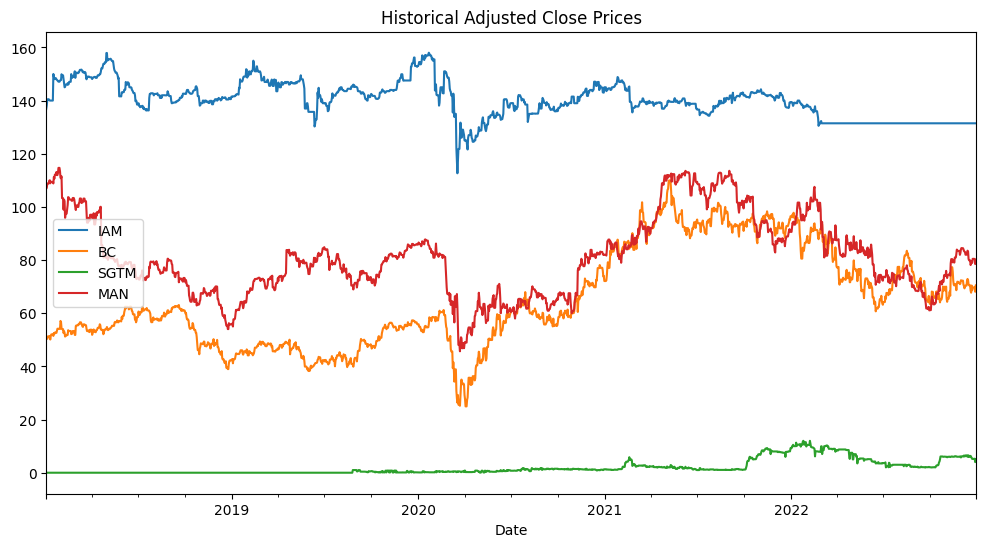

In [19]:
# Plot the time series data
historical_data.plot(figsize=(12,6))
plt.title('Historical Adjusted Close Prices')
plt.show()

In [20]:
# Check for duplicates in the entire DataFrame
duplicates = historical_data.duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()

# Display the number of duplicates
print("Number of duplicates:", num_duplicates)

# Show the rows with duplicates
duplicate_rows = historical_data[duplicates]
print("Duplicate rows:")
print(duplicate_rows)

Number of duplicates: 565
Duplicate rows:
                   IAM         BC   SGTM         MAN
Date                                                
2018-01-06  140.500000  51.251049  0.001  108.819801
2018-01-07  140.500000  51.251049  0.001  108.819801
2018-01-13  140.000000  52.036617  0.001  109.393105
2018-01-14  140.000000  52.036617  0.001  109.393105
2018-01-15  140.000000  52.036617  0.001  109.393105
...                ...        ...    ...         ...
2022-12-17  131.449997  70.505325  5.979   79.906494
2022-12-18  131.449997  70.505325  5.979   79.906494
2022-12-24  131.449997  69.714890  5.200   80.463539
2022-12-25  131.449997  69.714890  5.200   80.463539
2022-12-26  131.449997  69.714890  5.200   80.463539

[565 rows x 4 columns]


## Exploratory Data Analysis (EDA)

Handling Outliers : We detect and handle outliers using the Interquartile Range (IQR) method.

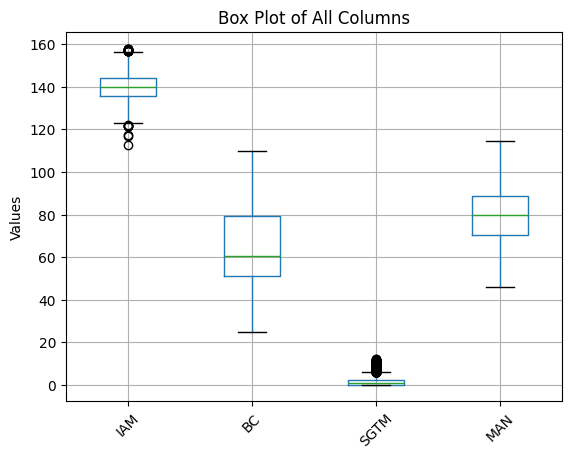

In [21]:
# Create box plots for all columns in the DataFrame
historical_data.boxplot()

# Add title and labels
plt.title('Box Plot of All Columns')
plt.ylabel('Values')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [22]:
# Handle outliers in the column "SGTM" using the Interquartile Range (IQR) method
column = 'SGTM'

Q1 = historical_data[column].quantile(0.25)
Q3 = historical_data[column].quantile(0.75)
IQR = Q3 - Q1

filter = (historical_data[column] >= Q1 - 1.5 * IQR) & (historical_data[column] <= Q3 + 1.5 *IQR)
historical_data = historical_data.loc[filter]  

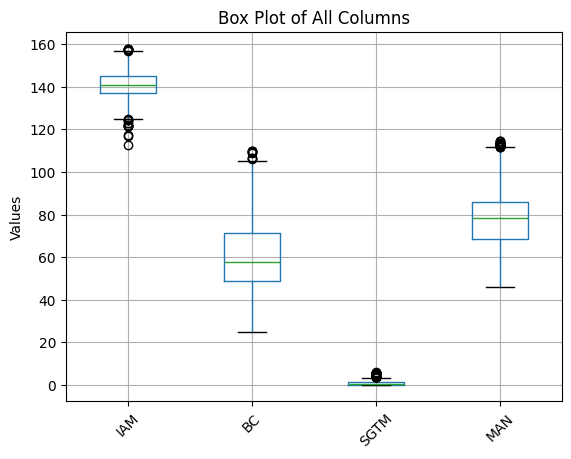

In [23]:
# Create box plots for all columns in the DataFrame
historical_data.boxplot()

# Add title and labels
plt.title('Box Plot of All Columns')
plt.ylabel('Values')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [24]:
# Handle outliers in the column "MAN" using the Interquartile Range (IQR) method
column = 'MAN'

Q1 = historical_data[column].quantile(0.25)
Q3 = historical_data[column].quantile(0.75)
IQR = Q3 - Q1

filter = (historical_data[column] >= Q1 - 1.5 * IQR) & (historical_data[column] <= Q3 + 1.5 *IQR)
historical_data = historical_data.loc[filter]  

# Handle outliers in the column "BC" using the Interquartile Range (IQR) method
column = 'BC'

Q1 = historical_data[column].quantile(0.25)
Q3 = historical_data[column].quantile(0.75)
IQR = Q3 - Q1

filter = (historical_data[column] >= Q1 - 1.5 * IQR) & (historical_data[column] <= Q3 + 1.5 *IQR)
historical_data = historical_data.loc[filter]  

# Handle outliers in the column "IAM" using the Interquartile Range (IQR) method
column = 'IAM'

Q1 = historical_data[column].quantile(0.25)
Q3 = historical_data[column].quantile(0.75)
IQR = Q3 - Q1

filter = (historical_data[column] >= Q1 - 1.5 * IQR) & (historical_data[column] <= Q3 + 1.5 *IQR)
historical_data = historical_data.loc[filter]  

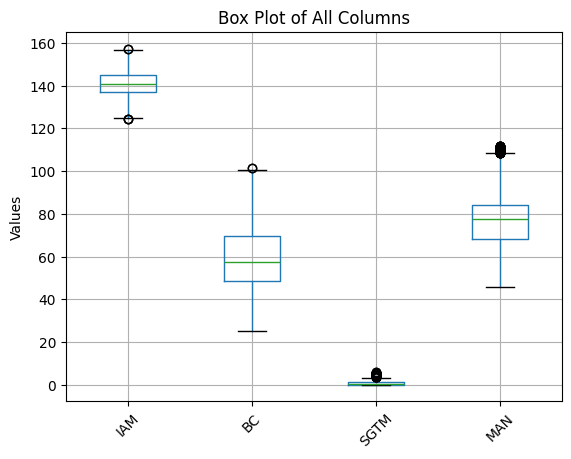

In [25]:
# Create box plots for all columns in the DataFrame
historical_data.boxplot()

# Add title and labels
plt.title('Box Plot of All Columns')
plt.ylabel('Values')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [26]:
# Exploring more ou cleaned dataframe
historical_data.describe()

,IAM,BC,SGTM,MAN
count,1495.000000,1495.000000,1495.000000,1495.000000
mean,140.979531,61.269889,0.965974,78.784542
std,6.544548,16.634094,1.303859,14.117181
min,124.500000,24.956461,0.001000,45.685677
25%,136.949997,48.589939,0.001000,68.314606
50%,141.000000,57.375137,0.400000,77.592346
75%,145.000000,69.768066,1.350000,84.363647
max,157.399994,101.594559,5.740000,111.849121


Correlation Analysis : We analyze the correlation between stock returns to understand their relationships.

In [27]:
# Correlation matrix of adjusted close prices
correlation_matrix = historical_data.corr()
print(correlation_matrix)

           IAM        BC      SGTM       MAN
IAM   1.000000 -0.167072 -0.493888  0.290578
BC   -0.167072  1.000000  0.604223  0.608289
SGTM -0.493888  0.604223  1.000000  0.141044
MAN   0.290578  0.608289  0.141044  1.000000


In [28]:
# Correlation matrix of the returns
# Calculate monthly returns
monthly_returns = historical_data.pct_change()

# Drop the first row which contains NaN values
monthly_returns = monthly_returns.dropna()

# Create correlation matrix
correlation_matrix = monthly_returns.corr()

# Display correlation matrix
print(correlation_matrix)

           IAM        BC      SGTM       MAN
IAM   1.000000  0.228275  0.012791  0.214607
BC    0.228275  1.000000 -0.009913  0.605382
SGTM  0.012791 -0.009913  1.000000  0.000900
MAN   0.214607  0.605382  0.000900  1.000000


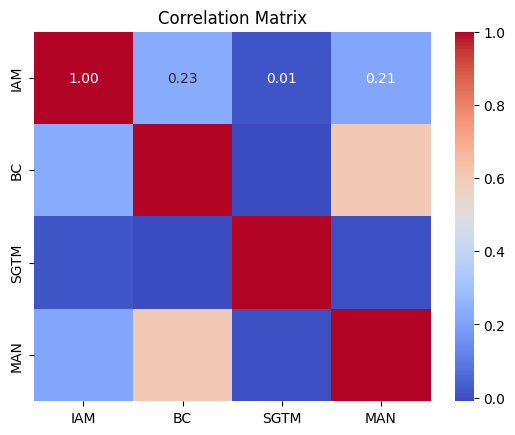

In [29]:
# Heatmap of correlation matrix of the returns
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Pairplot : We create pairplots to visualize relationships between variables.

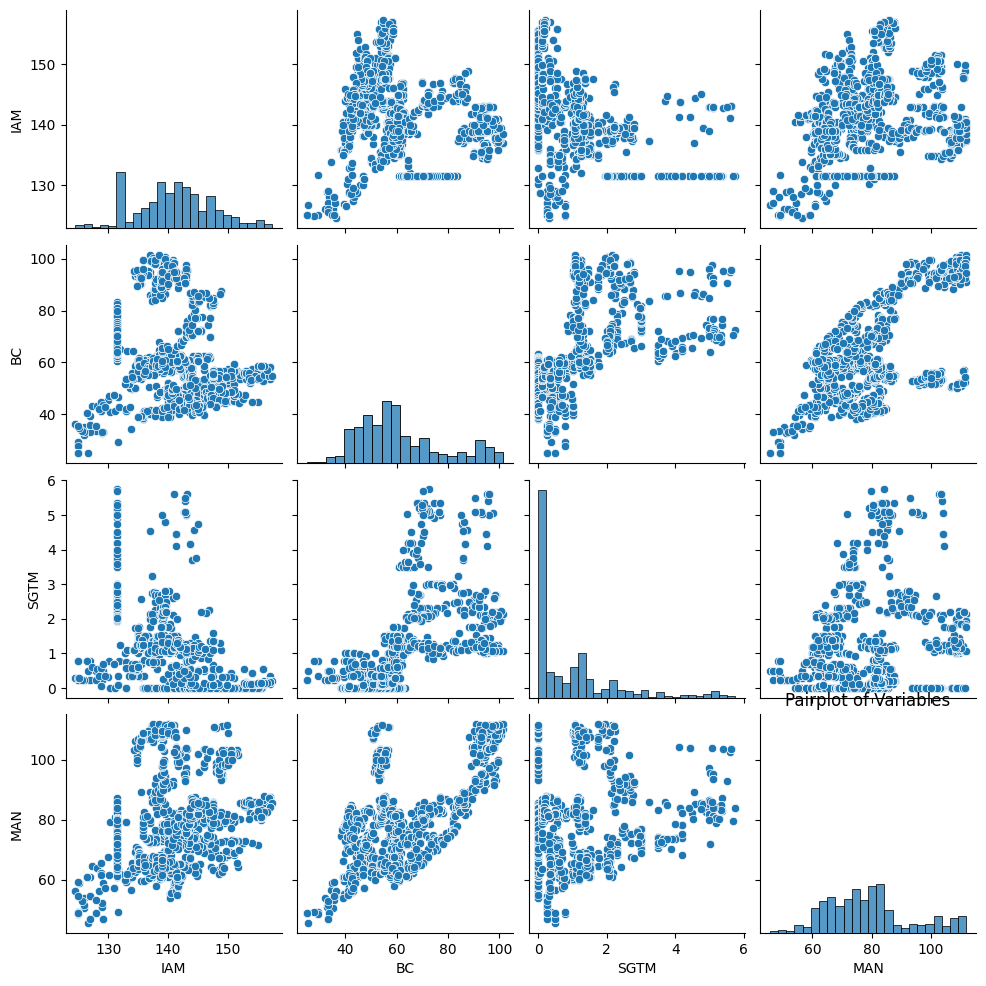

In [30]:
# Pairplot for visualizing relationships between variables
sns.pairplot(historical_data)
plt.title('Pairplot of Variables')
plt.show()

In [31]:
# Define the scaler object
scaler = StandardScaler()

# Apply standardization to your data
standardized_data = scaler.fit_transform(historical_data)

# Convert the standardized array back to a DataFrame with original column names
historical_data = pd.DataFrame(standardized_data, columns=historical_data.columns)

In [32]:
# selecting gpu
device = torch.device('cuda')

In [33]:
historical_data.shape

(1495, 4)

## LSTM Model Training

Data Preparation : We prepare the data for LSTM training by creating input-output pairs.

In [34]:
def create_xy(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        end_ix = i + time_step
        if end_ix > len(data)-1:
            break
        seq_x = data[i:end_ix]
        X.append(seq_x)
        y.append(data[end_ix])
    return np.array(X), np.array(y)

In [35]:
# Evaluation metrics functions
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MPE(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

# Function to evaluate model performance
def evaluate_model(model, X, y):
    outputs = model(X)
    y_pred = outputs.detach().numpy()
    y_true = y.detach().numpy()
    
    mae = MAE(y_true, y_pred)
    mse = MSE(y_true, y_pred)
    rmse = RMSE(y_true, y_pred)
    mape = MAPE(y_true, y_pred)
    mpe = MPE(y_true, y_pred)
    
    return mae, mse, rmse, mape, mpe

LSTM Model Definition and Training : We define and train LSTM models for each asset.

In [36]:
assets= ['IAM', 'BC', 'SGTM', 'MAN']

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        out = out.squeeze()  # Squeeze out the extra dimension
        return out

# Define the loss function and optimizer
criterion = nn.MSELoss()

# Define the ratio for splitting data into train and validation sets
train_ratio = 0.8  # 80% of data for training, 20% for validation

# Training loop
epochs = 100
model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'], columns=assets)

# Initialize an empty dictionary to store predictions for each asset
all_predictions = {}

for ticker in historical_data.columns:
    # Split the data into features (X) and target (y)
    X, y = create_xy(historical_data[ticker].values, time_step=100)
    
    # Split data into training and validation sets
    split_index = int(len(X) * train_ratio)
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # Convert datasets to tensors
    X_train_tensors = torch.from_numpy(X_train).float()
    X_val_tensors = torch.from_numpy(X_val).float()
    y_train_tensors = torch.from_numpy(y_train).float()
    y_val_tensors = torch.from_numpy(y_val).float()

    # Add the missing input_dim dimension
    X_train_tensors = X_train_tensors.unsqueeze(-1)  # Add a new dimension at the end
    X_val_tensors = X_val_tensors.unsqueeze(-1)  # Add a new dimension at the end

    # Instantiate the model with input_dim=1
    model = LSTMModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)  # Added weight_decay parameter to Adam optimizer

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensors)
        loss = criterion(outputs, y_train_tensors)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensors)
        val_loss = criterion(val_outputs, y_val_tensors)
        print(f'Validation Loss: {val_loss.item():.4f}')

    # Store the predictions for the current asset
    all_predictions[ticker] = model(X_val_tensors).squeeze().detach().numpy()

    # Evaluate the model performance
    mae, mse, rmse, mape, mpe = evaluate_model(model, X_val_tensors, y_val_tensors)
    model_perf_df[ticker] = [mae, mse, rmse, mape, mpe]

Epoch [1/100], Loss: 0.9100
Epoch [11/100], Loss: 0.1663
Epoch [21/100], Loss: 0.0671
Epoch [31/100], Loss: 0.0455
Epoch [41/100], Loss: 0.0406
Epoch [51/100], Loss: 0.0380
Epoch [61/100], Loss: 0.0357
Epoch [71/100], Loss: 0.0346
Epoch [81/100], Loss: 0.0340
Epoch [91/100], Loss: 0.0335
Validation Loss: 0.0162
Epoch [1/100], Loss: 0.9617
Epoch [11/100], Loss: 0.0651
Epoch [21/100], Loss: 0.0212
Epoch [31/100], Loss: 0.0142
Epoch [41/100], Loss: 0.0114
Epoch [51/100], Loss: 0.0104
Epoch [61/100], Loss: 0.0101
Epoch [71/100], Loss: 0.0098
Epoch [81/100], Loss: 0.0097
Epoch [91/100], Loss: 0.0096
Validation Loss: 0.0223
Epoch [1/100], Loss: 0.4750
Epoch [11/100], Loss: 0.0566
Epoch [21/100], Loss: 0.0403
Epoch [31/100], Loss: 0.0247
Epoch [41/100], Loss: 0.0219
Epoch [51/100], Loss: 0.0201
Epoch [61/100], Loss: 0.0196
Epoch [71/100], Loss: 0.0194
Epoch [81/100], Loss: 0.0191
Epoch [91/100], Loss: 0.0189
Validation Loss: 0.1079
Epoch [1/100], Loss: 0.7748
Epoch [11/100], Loss: 0.1481
Epoc

## Model Performance

In [37]:
model_perf_df.head()

,IAM,BC,SGTM,MAN
MAE,0.042742,0.100866,0.199447,0.098782
MSE,0.016174,0.022295,0.107930,0.022360
RMSE,0.127178,0.149314,0.328527,0.149534
MAPE,89.373440,20.641936,20.254809,30.464321
MPE,1.293550,-5.430422,-0.151117,2.943259


In [38]:
all_predictions[ticker].shape

(279,)

## Visualizing Predictions

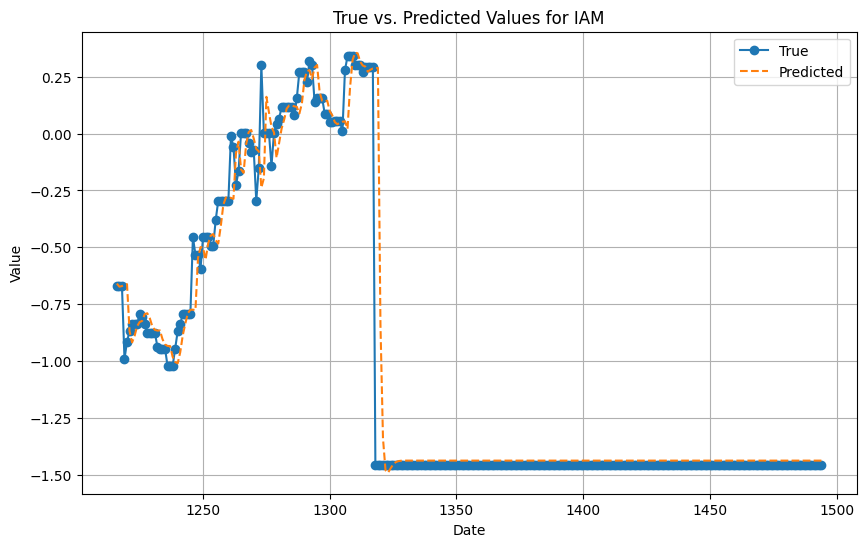

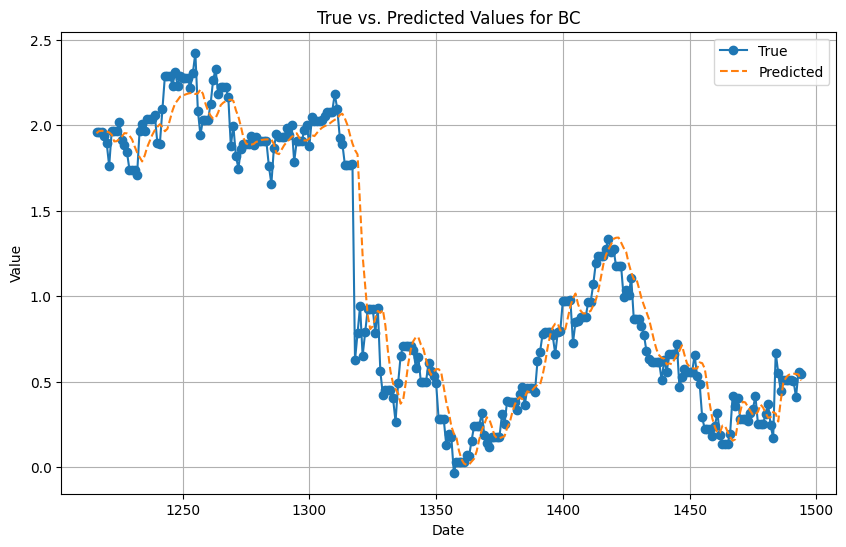

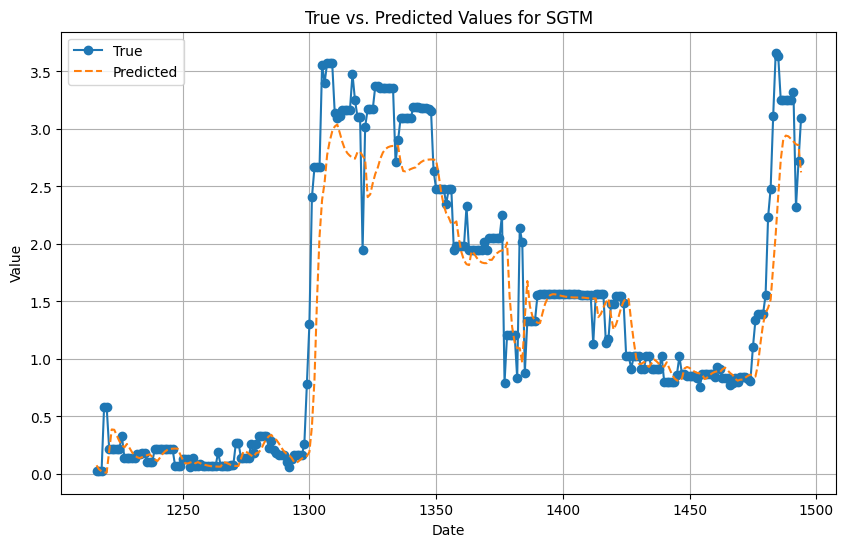

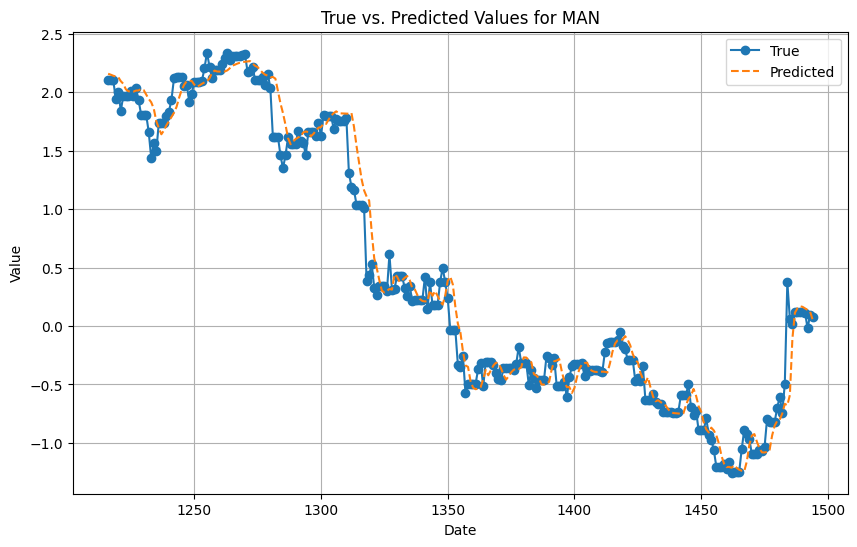

In [43]:
# Plot true and predicted values for each asset
for ticker in historical_data.columns:
    # Get the true and predicted values for the current asset
    y_true = historical_data[ticker][-len(all_predictions[ticker]):]  # Get corresponding true values
    y_pred = all_predictions[ticker]

    # Plot true and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_true.index, y_true, label='True', marker='o')
    plt.plot(y_true.index, y_pred, label='Predicted', linestyle='--')

    # Add labels, legend, and title
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'True vs. Predicted Values for {ticker}')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

## Model Saving

In [44]:
# Save PyTorch LSTM Model
torch.save(model.state_dict(), 'lstm_model.pth')